### Mateusz Kądziela, 148271
### Mateusz Serek, 148284
Source code and more readable pseudocode available [here](https://github.com/MatKadd/EC_2023/tree/main/lab4).

In [1]:
import pandas as pd
import time
import numpy as np
from prettytable import PrettyTable 
from numba.typed import List

In [2]:
from visualizations import visualize_solution, visualize_stats
from utils import calculate_distances, evaluate_solution
from algorithms import get_random_solution, get_edge_neigh, steepest

# Read data and calculate distances

In [3]:
C = pd.read_csv("../data/TSPC.csv", sep=";", header=None)
C.name = "Instance C"

instances = [C]

In [4]:
distances = calculate_distances(C)

# Create list of sets. Each set corresponds to candidate edges for each node.

In [5]:
candidate_distances = np.copy(distances)
np.fill_diagonal(candidate_distances, 1e9)

In [6]:
candidates = np.argsort(candidate_distances, axis=1)[:,:10]

In [7]:
candidate_edges = List()
for i in range(200):
    temp_cand = set()
    for j in range(10):
        temp_cand.add(candidates[i, j])
    candidate_edges.append(temp_cand)

C:\Users\User\miniconda3\envs\ec_labs\lib\site-packages\numba\typed\typedlist.py:82: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 'item' of function 'impl_append.<locals>.impl'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\User\miniconda3\envs\ec_labs\lib\site-packages\numba\typed\listobject.py", line 599:

    def impl(l, item):
    ^

  l.append(item)
C:\Users\User\miniconda3\envs\ec_labs\lib\site-packages\numba\core\ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 'item' of function '_append'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\User\miniconda3\envs\ec_l

# As stated in the task, we used best neighborhood from previous exercise (edge to edge exchange), random starting solution and steepest local search

Min score for candidate moves: 48881
Max score for candidate moves: 54008
Avg score for candidate moves: 51468.755


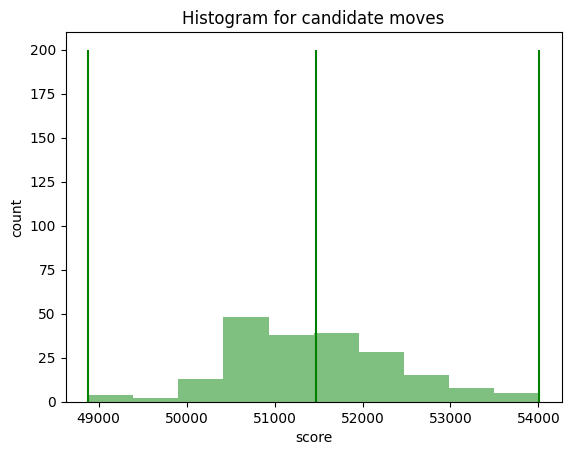

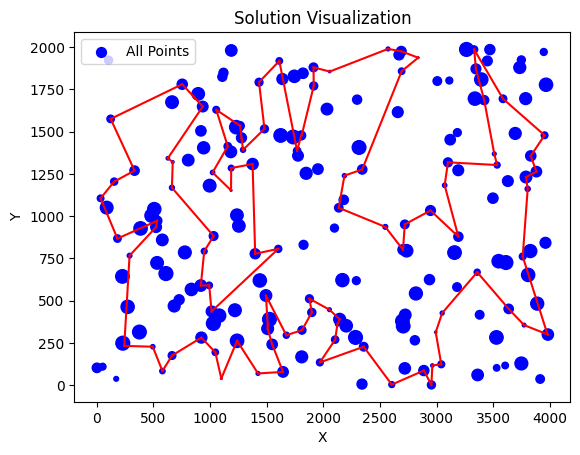

In [8]:
start = time.perf_counter()

start_solutions = [get_random_solution(start_node=_) for _ in range(200)]
final_solutions = []
for solution in start_solutions:
    while True:
        neigh = get_edge_neigh(solution, candidate_edges)
        solution, improvement = steepest(solution, neigh, distances)
        if improvement == 0:
            break
    final_solutions.append((solution, evaluate_solution(solution, distances)))

end = time.perf_counter()
time_passed = end - start
avg_time = time_passed / 200
scores = [solution[1] for solution in final_solutions]
avg_score = np.mean(scores)
visualize_stats(scores, 'candidate moves')
visualize_solution(C, max(final_solutions, key=lambda solution: solution[1])[0])

In [9]:
table = PrettyTable(["Method", "Avg time for one solution", "Avg score for method"]) 
table.add_row(['candidate moves', avg_time, avg_score])
table.add_row(['no candidate moves', 0.078, 51488.11])
print(table)

+--------------------+---------------------------+----------------------+
|       Method       | Avg time for one solution | Avg score for method |
+--------------------+---------------------------+----------------------+
|  candidate moves   |     0.1674817824998172    |      51468.755       |
| no candidate moves |           0.078           |       51488.11       |
+--------------------+---------------------------+----------------------+


# Conclusions

When we compare the approach with and without candidate moves, we clearly see that both of them have very similar average score, which is expected. What is not expected is that the average time for using candidate moves is higher than not using them. It may seem wrong, but actually due to the fact that we are using numba it makes sense. Numba doesn't support set types as of today (should be implemented in some future), so it has to use normal python sets and their operations, which actually slow the algorithm down a lot (warning we got when creating candidate moves). When we checked, how much smaller the neighborhood size was, we found out that using candidate moves reduced it around 10 times.